# Segmentación de clientes

Data Source: UCI Machine LearningRepository

Las empresas más exitosas hoy en día son las que conocen tan bien a sus clientes que pueden anticiparse a sus necesidades.
Esto es posible mediante la segmentación de clientes y el análisis de comportamiento/cohortes.

El análisis de cohortes es una técnica analítica y poderosa para agrupar clientes y habilitar el negocio personalizando la oferta de sus productos y estrategias de marketing.

Tipos de cohortes
- Tiempo: Clientes que se inscribieron en un producto o servicio durante un periodo de tiempo en común
- Comportamiento: Clientes que compraron un producto o servicio en común
- Tamaño: Clientes que gastaron un cierto monto acumulado en un periodo de tiempo en común

Este proyecto se enfocará en el análisis de cohorte de Tiempo.
Segmentaremos a los clientes en grupos de adquisición basados en el número de meses transcurridos desde su última adquisición.
Se visualizará un mapa de calor con métricas como la retención y el valor de gasto promedio.

# Ejecución end-to-end de proyecto: Pasos claves
1. Recopilar datos
2. Pre-Procesar datos
3. Explorar datos y definir el número óptimo de clusterings
4. Ejecutar el K-means clustering
5. Analizar y visualizar resultados

# 1. Recopilar datos
## 1.1. Importar librerías

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime

## 1.2. Importar datos

In [2]:
online = pd.read_csv('dataset.csv')
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [3]:
# Convertir InvoiceDate a datetime
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

# Crear función que trunca un objeto de fecha dado el primer día del mes
def get_month(x): return dt.datetime(x.year, x.month, 1) 

#Aplicar función a columna InvoiceDate y crear columna InvoiceMonth
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month) 

# Agrupar por CustomerID y seleccionar valores de InvoiceMonth
grouping = online.groupby('CustomerID')['InvoiceMonth'] 

# Usar transform() junto con min() para asignar el menor valor de InvoiceMonth a cada cliente
# CohortMonth es el mes de la más reciente adquisición del cliente
online['CohortMonth'] = grouping.transform('min')

# Revisar los 5 primeras columnas
online.head()

NameError: name 'dt' is not defined

In [ ]:
# Calcular el desplazamiento de tiempo
# Crear una función para extraer valores enteros en años, meses y días
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Calcular el número de meses entre la primera y última transacción/adquisición por cada cliente
invoice_year, invoice_month, _ = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(online, 'CohortMonth')

# Calcular la diferencia en años
years_diff = invoice_year - cohort_year

# Calcular la diferencia en meses
months_diff = invoice_month - cohort_month

# Convertir CohortMonth a formate 'date'
online['CohortMonth'] = pd.to_datetime(online['CohortMonth']).dt.date

# Extraer la diferencia en meses desde la primera transacción/adquisión por cliente
online['CohortIndex'] = years_diff * 12 + months_diff
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,6
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,2
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,0
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,0
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,3


## 1.3. Definir métricas comerciales

1. Retención de clientes = % de clientes que volvieron en los siguientes períodos (clientes activos)
2. Cantidad de transacciones/adquisiones promedio por período de tiempo
2. Valor de gasto promedio por período de tiempo

In [ ]:
# Crear DataFrame grouping para agrupar datos basados en CohortMonth y CohortIndex
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

# Contar el número de valores únicos por CustomerID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Crear tabla pivote
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,716.0,246.0,221.0,251.0,245.0,285.0,249.0,236.0,240.0,265.0,254.0,348.0,172.0
2011-01-01,332.0,69.0,82.0,81.0,110.0,90.0,82.0,86.0,104.0,102.0,124.0,45.0,NaN
2011-02-01,316.0,58.0,57.0,83.0,85.0,74.0,80.0,83.0,86.0,95.0,28.0,NaN,NaN
2011-03-01,388.0,63.0,100.0,76.0,83.0,67.0,98.0,85.0,107.0,38.0,NaN,NaN,NaN
2011-04-01,255.0,49.0,52.0,49.0,47.0,52.0,56.0,59.0,17.0,NaN,NaN,NaN,NaN
2011-05-01,249.0,40.0,43.0,36.0,52.0,58.0,61.0,22.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,207.0,33.0,26.0,41.0,49.0,62.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,173.0,28.0,31.0,38.0,44.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,139.0,30.0,28.0,35.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- CohortMonth es el mes de la primera transacción/adquisición del cliente
- InvoiceMonth es el mes de la última transacción/adquisición del cliente
- CohortIndex es la cantidad de meses que pasaron entre la primera transacción hasta la más reciente

Los valores de la columna 0 del DataFrame representa la cantidad de clientes que tuvieron su primera transacción/adquisición por mes.

En el siguiente DataFrame, los valores de las columnas 1 al 12 del DataFrame representa el porcentaje de esos clientes que volvieron a realizar una transacción/adquisición en los siguientes meses.

Interpretación de HeatMap:

- “Sólo el 22% de los clientes que compraron (por primera vez) nuestros productos en julio 2011, volvieron a comprar 03 meses después”. 
- “El 49% de los clientes que compraron (por primera vez) nuestros productos en diciembre 2010, volvieron a comprar 11 meses después. Convirtiendo a noviembre 2011 como el mes con mayor % de retención de clientes”.

In [ ]:
# Seleccionar la primera columna y guardarlo como cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Dividir cohort_counts por cohort_sizes en todas las filas
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3)*100

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,34.4,30.9,35.1,34.2,39.8,34.8,33.0,33.5,37.0,35.5,48.6,24.0
2011-01-01,100.0,20.8,24.7,24.4,33.1,27.1,24.7,25.9,31.3,30.7,37.3,13.6,NaN
2011-02-01,100.0,18.4,18.0,26.3,26.9,23.4,25.3,26.3,27.2,30.1,8.9,NaN,NaN
2011-03-01,100.0,16.2,25.8,19.6,21.4,17.3,25.3,21.9,27.6,9.8,NaN,NaN,NaN
2011-04-01,100.0,19.2,20.4,19.2,18.4,20.4,22.0,23.1,6.7,NaN,NaN,NaN,NaN
2011-05-01,100.0,16.1,17.3,14.5,20.9,23.3,24.5,8.8,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,15.9,12.6,19.8,23.7,30.0,9.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,16.2,17.9,22.0,25.4,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.6,20.1,25.2,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


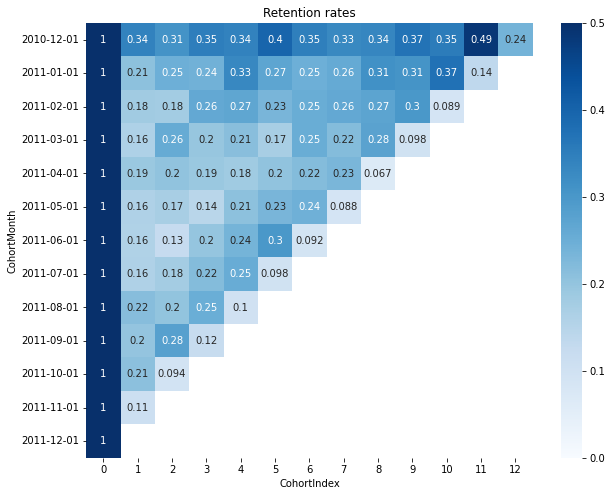

In [ ]:
# Visualizar las tasas de retención como un mapa de calor
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.title('Retention rates')
sns.heatmap(data = retention,
            annot = True,
            vmin = 0.0,
            vmax = 0.5,
            cmap = 'Blues')
plt.show()

# 2. Pre-Procesar datos

## 2.1. Filtrar datos de los últimos 12 meses

El objetivo de este proyecto es analizar la información comercial de los últimos 12 meses, 
modifiqué la última versión del dataset 'online.csv' a 'online12M.csv' filtrando sólo los datos de los últimos 12 meses.

El siguiente script permitirá la aplicación del script en múltiples datasets, filtrando sólo la data de los úlitmos 12 meses.

In [ ]:
online12M = pd.read_csv('dataset12M.csv')
print('Min:{}; Max:{}'.format(min(online12M.InvoiceDate),
max(online12M.InvoiceDate)))
online12M.head()

Min:2010-12-10; Max:2011-12-09


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


## 2.2. Segmentación RFM (Recency, Frequency and Monetary) por cliente

Segmentación de conducta de cliente basado en 03 métricas:
- Recency: Mide la cantidad de días que han pasado desde la última compra que hizo el cliente durante los últimos 12 meses.
- Frequency: Mide la cantidad acumulada de las veces que el cliente compró durante los últimos 12 meses.
- MonetaryValue: Mide la cantidad acumulada de dinero que el cliente ha gasto en nuestros productos en los últimos 12 meses.

Lo siguiente es agrupar a los clientes en algún tipo de categorización (alta, media, baja)

Los valores RFM pueden agruparse de diversas maneras:
- Percentiles e.q. quantiles: Agrupar a los clientes en grupos de igual tamaño según valores de percentil de cada métrica (R/F/M)
- Pareto 80/20 cut: Asignar un valor alto o bajo a cada métrica en función de una división de Pareto 80/20 %
- Custom - based on business knowledge: Definición de umbrales comerciales para cada métrica

Proceso de cálculo de percentiles:
1. Ordenar clientes según la métrica
2. Dividir a los clientes en un número predefinido de grupos de igual tamaño
3. Asignar una etiqueta a cada grupo

Nota:
- La puntuación más alta para la mejor métrica, aunque lo mejor no siempre es lo más alto (Recency).
- En este caso, la etiqueta es inversa - cuanto más reciente sea el cliente, mejor.

In [ ]:
# Crear la columna TotalSum
online12M['TotalSum'] = online12M['Quantity'] * online12M['UnitPrice']
online12M.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom,12.60
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom,1.45
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom,22.50
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom,2.10
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom,17.85


In [ ]:
# Crear la columna TotalSum
online12M['TotalSum'] = online12M['Quantity'] * online12M['UnitPrice']

# Convertir InvoiceDate a formato 'datetime'
online12M['InvoiceDate'] = pd.to_datetime(online12M['InvoiceDate'])

# Crear snapshot_date para seleccionar la fecha más reciente de todo el dataset, sumar 1 para simular que es el día que hacemos el análisis
snapshot_date = max(online12M.InvoiceDate) + datetime.timedelta(days=1)

# Agrupar los datos por CustomerID
datamart = online12M.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Fecha del día del análisis - Fecha del InvoiceDate más reciente por cliente
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Renombar columnas para una fácil interpretación
datamart.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

# Datamart es una tabla donde las filas son cada cliente con su antiguedad, frecuencia y valor monetario al día de hoy.            
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


## 2.3. Segmentación de RFM_Segment y RFM_Score por cliente

Ahora agruparemos a los clientes en 04 segmentos del mismo tamaño para cada métrica RFM.

1. Crear un generador de valores de etiquetas con range().
2. Definir el orden de las etiquetas, dependiendo de el alto valor de la métrica debe ser buena o mala
3. Concatenar los valores del cuartil de RFM en columna RFM_Segment
4. Sume los valores de los cuartiles de RFM en columna RFM_Score

"Se busca filtrar a los clientes que gastan más y adquieran nuestros productos más a menudo"


In [ ]:
# Crear etiquetas para Recency, Frequency y MonetaryValures
r_labels = range(4, 0, -1) #[3, 2, 1] Clientes que han estado activos más recientemente serán mejor que los clientes menos recientes
f_labels = range(1, 5) #[1, 2, 3]
m_labels = range(1, 5) #[1, 2, 3]

# Asignar esas etiquetas a 04 grupos de percentiles de igual tamaño
r_groups = pd.qcut(datamart['Recency'], q=4, labels=r_labels)
f_groups = pd.qcut(datamart['Frequency'], q=4, labels=f_labels)
m_groups = pd.qcut(datamart['MonetaryValue'], q=4, labels=m_labels)

# Crear nuevas columnas R, F y M en Datamart
datamart = datamart.assign(R=r_groups.values, F=f_groups.values, M= m_groups.values)

# Convertir columnas a formato 'int' y concatenar los quartiles de RFM en columna RFM_Segment
def join_rfm(x): return str(x['R'].astype(int)) + str(x['F'].astype(int)) + str(x['M'].astype(int))
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

# Calcular RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,3,25,948.70,4,4,4,444,12
12748,1,888,7046.16,4,4,4,444,12
12749,4,37,813.45,4,4,4,444,12
12820,4,17,268.02,4,3,3,433,10
12822,71,9,146.15,2,2,3,223,7


## 2.4. Análisis RFM_Segment y RFM_Score


- Siempre investigar el tamaño del segmento antes de usarlos para las aplicaciones comerciales
- Filtraremos los 10 RFM_Segment con mayor cantidad de clientes
- Los segmentos RFM_Segment más altos (444) y más bajos (111) tienen 372 y 345 clientes, respectivamente.

In [ ]:
# Datamart RFM_Segment
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    372
111    345
211    169
344    156
233    129
222    128
333    120
122    117
311    114
433    113
dtype: int64

El análisis RFM_Segment nos permite determinar quiénes son los clientes que pertenencen a un determinado segmento.

Por ejemplo, si quisiéramos saber quiénes son los clientes que pertenencen al segmento 444 (alto Recency, alto Frequency y alto MonetaryValue):

In [ ]:
datamart[datamart['RFM_Segment']=='444']

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,3,25,948.70,4,4,4,444,12
12748,1,888,7046.16,4,4,4,444,12
12749,4,37,813.45,4,4,4,444,12
12839,3,54,947.63,4,4,4,444,12
12841,5,70,630.95,4,4,4,444,12
...,...,...,...,...,...,...,...,...
18225,4,56,1175.02,4,4,4,444,12
18229,12,30,1626.54,4,4,4,444,12
18245,8,40,673.61,4,4,4,444,12


## 2.5. Resúmenes estadísticos por RFM_Score

Mientras que RFM_Segment nos permite filtrar clientes con una amplia variedad de segmentos, RFM_Score nos permite hacer resúmenes estadísticos de cada métrica RFM por cada nivel de RFM_Score:

In [ ]:
# Analizar resúmenes estadísticos de parámetros RFM por niveles RFM_Segment
datamart.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
               mean      mean          mean count
RFM_Segment                                      
111           246.9       2.1          28.4   345
112           234.5       2.9          82.4   105
113           254.1       2.3         202.6    42
114           225.9       2.2        1434.6    16
121           246.5       6.5          38.4    63
...             ...       ...           ...   ...
433             9.2      14.5         229.2   113
434            10.5      16.7         776.4    71
442             9.4      27.1         101.3    18
443            10.3      38.6         231.1    67
444             8.0      75.6        1653.9   372

[62 rows x 4 columns]

In [ ]:
# Analizar resúmenes estadísticos de parámetros RFM por niveles RFM_Score
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           246.9       2.1          28.4   345
4           162.2       3.1          47.8   337
5           138.9       4.3          78.2   393
6           101.0       6.3         146.3   444
7            78.0       8.5         160.2   382
8            62.6      12.8         196.3   376
9            46.8      16.7         330.3   345
10           31.9      24.0         443.1   355
11           21.8      38.9         705.3   294
12            8.0      75.6        1653.9   372

## 2.6. Segmentación por etiquetas comerciales

En algunas ocasiones, tener muchos niveles de RFM_Score no es de mucha ayuda al buscar insights comerciales.

Una alternativa es agrupar a los clientes según su RFM_Score con una menor cantidad de segmentos mediante la asignación de etiquetas (Gold/Silver/Bronze).

In [ ]:
# Se establecerá límites en función a la cantidad de niveles RFM_Score
def segment_me(df):
    if df['RFM_Score'] >= 10:
        return 'Gold'
    elif (df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10):
        return 'Silver'
    else:
        return 'Bronze'

datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.head() 

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12747,3,25,948.70,4,4,4,444,12,Gold
12748,1,888,7046.16,4,4,4,444,12,Gold
12749,4,37,813.45,4,4,4,444,12,Gold
12820,4,17,268.02,4,3,3,433,10,Gold
12822,71,9,146.15,2,2,3,223,7,Silver


In [ ]:
# Analizar resúmenes estadísticos de parámetros RFM por niveles General_Segment
datamart.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            180.8       3.2          52.7  1075
Gold               20.3      47.1         959.7  1021
Silver             73.9      10.7         202.9  1547

En algunas ocasiones, tomar varias tomas de prueba-error para encontrar los puntos correctos de segmentación puede ser engorrozo, de baja precisión y traducirse en una mala toma de decisiones comerciales.

El agrupamiento de K-means es un modelo de machine learning ideal para la segmentación de clientes sin umbrales que son elegidos arbitrariamente (como lo hemos venido haciendo).

K-Means busca un balance entre tener una adecuada segmentación comercial de clientes y reducir en lo posible el error de pronóstico (SSE).

# 3. Explorar datos y definir el número óptimo de clusterings
K-means clustering es uno de los métodos de aprendizaje automático no supervisado más populares, sencillo y rápido.

# Supuestos claves de k-means clustering respecto a las variables (R/F/M)
1. Las variables deben tener distribuciones simétricas (Las variables sesgadas se gestionan con transformación logarítmica)
2. Las variables deben tener el mismo promedio (Para garantizar que se asigne la misma importancia a cada variable)
3. Las varialbes deben tener la misma varianza (Para garantizar que se asigne la misma importancia a cada variable)

## 3.1. Explorar datos para k-means clustering

Pasos

1. Explorar variables con distribuciones asimétricas - aplicarles transformación logarítimica
2. Normalizar/Estandarizar las variables con el mismo promedio
3. Normalizar/Estandarizar las variables con la misma varianza
4. Almacenar como un 'array' separado para ser usado posteriormente para el clustering

In [ ]:
# Filtrar columnas CustomerID, Recency, Frequency, MonetaryValue en un nuevo DataFrame
datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,3643.00000,3643.000000,3643.000000
mean,90.43563,18.714247,370.694387
std,94.44651,43.754468,1347.443451
min,1.00000,1.000000,0.650000
25%,19.00000,4.000000,58.705000
50%,51.00000,9.000000,136.370000
75%,139.00000,21.000000,334.350000
max,365.00000,1497.000000,48060.350000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

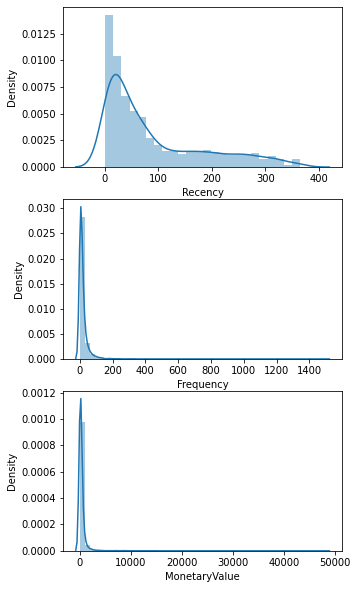

In [ ]:
# Graficar la distribución de las columnas Recency, Frequency y MonetaryValue
plt.figure(figsize=(5,10))
plt.subplot(3, 1, 1)
sns.distplot(datamart_rfm['Recency'])
plt.subplot(3, 1, 2)
sns.distplot(datamart_rfm['Frequency'])
plt.subplot(3, 1, 3)
sns.distplot(datamart_rfm['MonetaryValue'])

# Presentar gráfico
plt.show()


In [ ]:
# Las gráficas nos sugieren que las variables tiene un amplio rango de valores
# Aplicaremos la transformación logarítmica para eliminar, en la medida de lo posible, los sesgos
datamart_rfm_log = np.log(datamart_rfm)
datamart_rfm_log.describe()

,Recency,Frequency,MonetaryValue
count,3643.000000,3643.000000,3643.000000
mean,3.806481,2.171902,4.934900
std,1.352631,1.210321,1.310945
min,0.000000,0.000000,-0.430783
25%,2.944439,1.386294,4.072524
50%,3.931826,2.197225,4.915372
75%,4.934474,3.044522,5.812188
max,5.899897,7.311218,10.780213


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

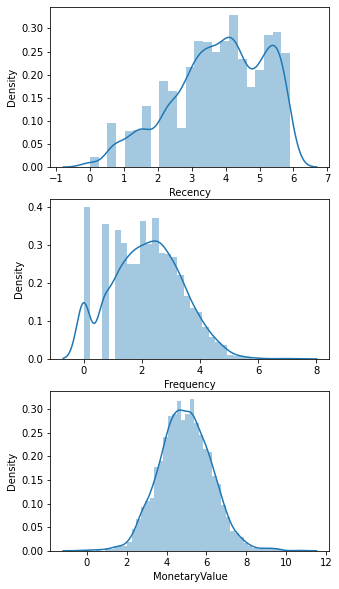

In [ ]:
# Graficar la distribución con transformación logarítmica de las columnas Recency, Frequency y MonetaryValue
plt.figure(figsize=(5,10))
plt.subplot(3, 1, 1)
sns.distplot(datamart_rfm_log['Recency'])
plt.subplot(3, 1, 2)
sns.distplot(datamart_rfm_log['Frequency'])
plt.subplot(3, 1, 3)
sns.distplot(datamart_rfm_log['MonetaryValue'])

# Presentar gráfico
plt.show()

In [ ]:
# Inicializar una escala de normalización
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Ajustar la escala de normalización
scaler.fit(datamart_rfm_log)

# Normalizar y centrar la data
datamart_rfm_normalized = scaler.transform(datamart_rfm_log)

# Crear un DataFrame con valores de variables normalizados
datamart_rfm_normalized = pd.DataFrame(datamart_rfm_normalized,
 index=datamart_rfm_log.index, columns=datamart_rfm_log.columns)

# Resumen estadístico de nuevo DataFrame
datamart_rfm_normalized.describe().round(2)


,Recency,Frequency,MonetaryValue
count,3643.00,3643.00,3643.00
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.81,-1.79,-4.09
25%,-0.64,-0.65,-0.66
50%,0.09,0.02,-0.01
75%,0.83,0.72,0.67
max,1.55,4.25,4.46


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

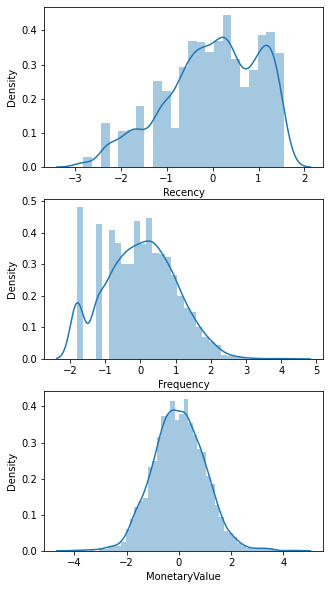

In [ ]:
# Graficar la distribución con transformación de normalización de las columnas Recency, Frequency y MonetaryValue
plt.figure(figsize=(5,10))
plt.subplot(3, 1, 1)
sns.distplot(datamart_rfm_normalized['Recency'])
plt.subplot(3, 1, 2)
sns.distplot(datamart_rfm_normalized['Frequency'])
plt.subplot(3, 1, 3)
sns.distplot(datamart_rfm_normalized['MonetaryValue'])

# Presentar gráfico
plt.show()

## 3.2. Definir el número óptimo de clusterings

Mediante el método 'Elbow criterion': Fácil de interpretar y brinda una buena estimación

Pasos
1. Graficar el número de clusters contra la suma de errores al cuadrado (SSE) dentro del cluster.
2. Identificar el "codo" en el gráfico: Punto donde disminuye la disminución de SSE y se vuelve algo marginal.
3. Definir el punto "codo" como k-means

(*)SSE: Suma de distancias al cuadrado desde cada punto de datos hasta su centro de clúster.

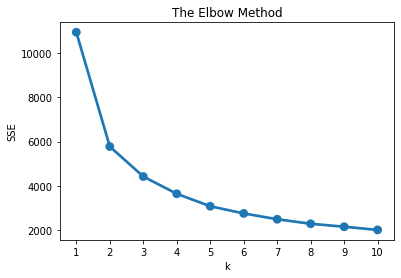

In [ ]:
# Importar librerías
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

# Entrenar el KMeans y calcular el SSE para cada *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_rfm_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# Graficar SSE para cada *k*
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

# 4. Ejecutar el K-means clustering
El gráfico The Elbow Method nos sugiere que los números óptimos de clustering son 2 y 3.

En esta ocasión, escogeré k-means=3 para una mejor flexibilidad en las estrategias comerciales y para incrementar la información en el resumen estadístico.

In [ ]:
# El gráfico The Elbow Method nos sugiere que 
# los números óptimos de clustering son 2 y 3.

# En esta ocasión, escogeré k-means=3 para 
# una mejor flexibilidad en las estrategias comerciales
# y para incrementar la información en el resumen estadístico.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=1)

# Calcular el k-means clustering sobre la data pre-procesada
kmeans.fit(datamart_rfm_normalized)

# Extraer etiquetas de cluster desde el atributo labels_
cluster_labels = kmeans.labels_

# 5. Analizar y visualizar resultados

Enfoques para construir perfiles de clientes:
1. Resúmenes estadísticos para cada clúster
    - Ejecutar la segmentación de k-means para varios valores de k alrededor del valor recomendado
    - Crear una columna de etiqueta de cluster en el datamart_rfm
    - Comparar los valores promedio de RFM de cada solución de agrupamiento
2. Snake plots
3. Importancia relativa de los atributos del segmento en la comparación con la población

## 5.1. Resúmenes estadísticios para cada clúster

In [ ]:
# Crear una columna de etiquetas de clúster en datamart_rfm
datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels)

# Calcular el promedio de los valores RFM
# y la cantidad de clientes por cada cluster
datamart_rfm_k3.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          16.0      50.0        1051.0   901
1         167.0       3.0          53.0  1156
2          77.0      12.0         216.0  1586

#### Insigths:
#### "El segmento 1 tiene 1,156 clientes que no han sido muy recientes, son mucho menos frecuentes con sus transacciones/adquisiciones y su valor monetario es mucho más bajo que el segmento 0".

#### "El segmento 0 tiene 901 clientes con transacciones/adquisiciones más recientes, tienen alta frecuencia con sus transacciones/adquisiones y su valor monetario es el más alto de todos los segmentos".

## 5.2. Snake Plots
Estos gráficos sirven para comprender y comparar segmentos

- Técnica de investigación de mercado para comparar diferentes segmentos
- Representación visual de los atributos de cada segmento
- Necesidad de normalizar/estandarizar los datos (centro y escala)
- Trazar los valores normalizados promedio del atributo de cada grupo

In [ ]:
# Preparar la data para el snake plot
# Transformar datamart_normalized como DataFrame y agregar una columna 'Cluster'
datamart_rfm_normalized = pd.DataFrame(datamart_rfm_normalized,
                                    index=datamart_rfm.index,
                                    columns=datamart_rfm.columns)
datamart_rfm_normalized['Cluster'] = datamart_rfm_k3['Cluster']

# Moldear los datos en un formato largo para que los valores RFM
#  y los nombres de las métricas se almacenan en una sóla columna
datamart_melt = pd.melt(datamart_rfm_normalized.reset_index(),
                        # Asignar CustomerID y Cluster como varialbles ID
                        id_vars=['CustomerID', 'Cluster'],
                        # Asignar RFM_Values como value_vars
                        value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                        var_name='Attribute',
                        value_name='Value')
datamart_melt


,CustomerID,Cluster,Attribute,Value
0,12747,0,Recency,-2.002202
1,12748,0,Recency,-2.814518
2,12749,0,Recency,-1.789490
3,12820,0,Recency,-1.789490
4,12822,2,Recency,0.337315
...,...,...,...,...
10924,18280,1,MonetaryValue,-0.975812
10925,18281,1,MonetaryValue,-1.125628
10926,18282,1,MonetaryValue,-1.152485
10927,18283,0,MonetaryValue,0.866422


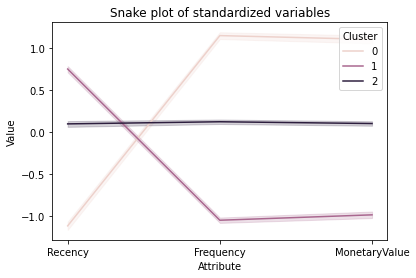

In [ ]:
# Graficar el snake plot
plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster',
            data=datamart_melt)

# Presentar gráfico
plt.show()

# 5.3. Importancia relativa de atributos de segmentos

Pasos
1. Calcular los valores promedio de cada grupo
2. Calcular los valores promedios de la población
3. Calcular el puntaje de importancia dividiéndolos y restando 1 (asegurando que retorne 0 cuando el promedio del grupo es igual al promedio de la población)

- El resultado es una puntuación de importancia relativa para cada valor RFM de los segmentos
- A medida que una relación se aleja de 0, la importancia del atributo para un segmento (en relación con la población total) aumenta
- El atributo es para definir un grupo específico en comparación con el promedio de la población

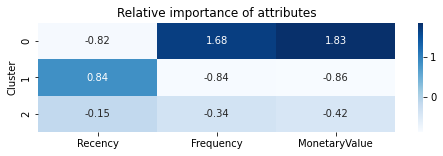

In [ ]:
# Calcular los valores promedio de RFM para cada Cluster de clientes
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()

# Calculate los valores promedio de RFM para la población total de clientes
population_avg = datamart_rfm.mean()

# Calcular la importancia relativa del valor del atributo del cluster 
# en comparación con la población
relative_imp = cluster_avg / population_avg - 1

# Imprimir puntajes de importancia relativa redondeados a 2 decimales
relative_imp.round(2)

# Graficar el heatmap
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues')

# Presentar el gráfico
plt.show()

# Conclusiones

1. La segmentación de clientes mediante métricas como Recency, Frequency y MonetaryValue permite a las empresas identificar tendencias sobre el comportamiento de los clientes: clientes más recientes, clientes más frecuentes, clientes que gastan más en productos/servicios
2. El análisis RFM_Segment permite a las empresas segmentar clientes en diferentes niveles con una gran flexibilidad en función a la prioridad de variables como Recency, Frecuency o MonetaryValue.
3. El análisis RFM_Score permite a las empresas elaborar resúmenes estadísticos por cada cliente o por cada nivel de RFM_Score. Así mismo, permite establecer etiquetas comerciales como 'Gold/Silver/Bronze' o 'Top/Middle/Bottom' necesarios para las estrategias de marketing.
4. Tanto RFM_Segment y RFM_Score tienen sus desventajas. La principal es que están sujetas a la subjetividad del equipo comercial al momento de segmentar clientes. Lo segundo es que no hay manera de saber cuál de las variables RFM son más importantes que otras en un determinado segmento ya que comparten diferentes magnitudes y sus valores no están estandarizados, o si una cantidad de segmentos es mejor que otra.
5. K-means clustering es un modelo de machine learning que permite segmentar clientes de manera óptima. Busca el equilibrio entre disminuir la suma de errores al cuadrado (SSE) en su clasificación y una adecuada cantidad de clusters para futuras estategias comerciales.

Ideas: La segmentación no solo de clientes sino también de productos de una empresa mediante métricas Recency, Frequency y MonetaryValue, y la aplicación de K-means con el objetivo de crear estrategias comerciales como:
- Aumentar la rotación de inventarios
- Exploración de nichos de mercado
- Incrementar el capital de trabajo en productos más comerciales
- Lanzar al mercado productos estacionales mediante un Relative 'Importance of Attributes' plot identificando los meses más comerciales para una cierta cantidad de productos

Elaborado por: Diego Beteta